<a href="https://colab.research.google.com/github/DelaramRajaei/multi_label_text_classification/blob/main/multi_label_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label text classification

** Dataset size is not enough to train the model. If we add more layers, it will overfit and on the other hand, if we use more dropout or regularization(methods to overcome overfitting) the model accuracy will we low and arround 50%.
However I manged to tackle the issue of overfitting and increase the accuracy up to 70%.

In [1]:
!nvidia-smi

Wed Feb 22 08:23:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Information



**Author:** [Farrokh Karimi](https://farrokhkarimi.github.io/)  
**Edited By:** [Delaram Rajaei](https://delaramrajaei.github.io/)  
**Description:** In this notebook, we want to classify the Ronash dataset into 20 category.

Edits can be found by "# Edited" tags.

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import torch

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from collections import Counter

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

## Dataset

### Download Dataset

In [3]:
# downloading Data from the Google Drive link
!gdown 1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy

Downloading...
From: https://drive.google.com/uc?id=1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy
To: /content/Ronash_DS_Assignment.csv
100% 1.05M/1.05M [00:00<00:00, 144MB/s]


In [4]:
ls

model.01-1.56.h5   model.17-2.67.h5   model.42-1.31.h5
model.01-15.88.h5  model.17-2.77.h5   model.42-1.39.h5
model.01-16.36.h5  model.17-2.89.h5   model.42-1.55.h5
model.01-16.43.h5  model.173-1.01.h5  model.42-1.56.h5
model.01-1.82.h5   model.173-1.15.h5  model.42-1.61.h5
model.01-1.91.h5   model.173-1.20.h5  model.42-1.68.h5
model.01-2.63.h5   model.174-1.01.h5  model.42-1.99.h5
model.01-2.64.h5   model.174-1.15.h5  model.42-2.05.h5
model.01-2.66.h5   model.174-1.20.h5  model.42-2.32.h5
model.01-2.67.h5   model.175-1.01.h5  model.42-2.61.h5
model.01-2.68.h5   model.175-1.15.h5  model.42-2.73.h5
model.01-2.70.h5   model.175-1.20.h5  model.43-1.16.h5
model.01-2.76.h5   model.176-1.00.h5  model.43-1.18.h5
model.01-2.78.h5   model.176-1.15.h5  model.43-1.26.h5
model.01-2.80.h5   model.176-1.19.h5  model.43-1.27.h5
model.01-2.81.h5   model.177-1.00.h5  model.43-1.32.h5
model.01-2.82.h5   model.177-1.14.h5  model.43-1.42.h5
model.01-2.83.h5   model.177-1.19.h5  model.43-1.53.h5
model.01-2

In [5]:
# reading the csv file as a dataframe
df = pd.read_csv('Ronash_DS_Assignment.csv')
df

,product_id,title,vendor,tags,category
0,3937721221199,Fidele Super Premium Adult Large Breed Dog Food,Fidele,"['Adult', 'Bangalore', 'Chennai', 'Chicken', '...",Animals & Pet Supplies
1,7353058033889,Foldable Pet Toys Linen Storage,Cap Point,[],Animals & Pet Supplies
2,6594773549129,Bok Dok Diaper,Pets Home,"['Brand_Pet Arabia', 'Category_Pets Home', 'Ca...",Animals & Pet Supplies
3,4802008318014,Tastybone Toy Chicken,TastyBone,[],Animals & Pet Supplies
4,1779705151539,Leather Leash Tab - Short Dog Leash,Mighty Paw,"['Leash', 'Leash Tab', 'Training']",Animals & Pet Supplies
...,...,...,...,...,...
5265,4637089464407,Candylab MOO Milk Van,Candylab,"['3 Years +', 'candylab', 'Discount Products',...",Vehicles & Parts
5266,4996632444987,"Truck - Modern Era Vehicles -- Red, White - S...",Woodland Scenics,"['HO Scale', 'ho-scale-items', 'vehicles', 'wo...",Vehicles & Parts
5267,5528541003927,Car Sticker Flags Decal American Flag Sticker for,Cyan Selene,['Other'],Vehicles & Parts
5268,1395163889730,Lazer Helmets Bayamo Pit Bull - Full Face,OPEN BOX BARGAINS,"['65061090', 'Antiscratch Pinlock Ready Visor'...",Vehicles & Parts


### Dataset Information

In [6]:
# counting the number of each label
df['category'].value_counts()

Apparel & Accessories        1000
Animals & Pet Supplies        500
Food, Beverages & Tobacco     400
Sporting Goods                400
Luggage & Bags                400
Home & Garden                 400
Health & Beauty               400
Media                         300
Toys & Games                  300
Furniture                     200
Baby & Toddler                200
Arts & Entertainment          200
Electronics                   100
Business & Industrial         100
Office Supplies               100
Vehicles & Parts              100
Hardware                       50
Cameras & Optics               50
Software                       50
Religious & Ceremonial         20
Name: category, dtype: int64

In [7]:
# counting how many indices are duplicated in each column
print(f"There are {sum(df['title'].duplicated())} duplicate title.")
print(f"There are {sum(df['vendor'].duplicated())} duplicate vondor.")
print(f"There are {sum(df['tags'].duplicated())} duplicate tags.")

There are 0 duplicate title.
There are 1256 duplicate vondor.
There are 716 duplicate tags.


In [8]:
# counting the number of Nan samples
df.isnull().values.sum()

3

There are just 3 Nan samples in the dataset and we delete them.

### Cleaning Dataset

In [9]:
# Edited
# Remove 3 rows with null values on the current dataframe.
df.dropna(axis=0, inplace=True)
# check if null values are removed properly.
df.isnull().values.sum()

0

In [10]:
# the function for extracting and standardizing the sentences
def text_extraction(dfi):
  # in this function, we concatenate text feature parts of the data as a sentence
  sentence = ' '.join([dfi['title'], str(dfi['vendor']), dfi['tags']])
  # Remove punctuations
  sentence = re.sub('[^a-zA-Z0-9$.]', ' ', sentence)
  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)
  # Changint to lowercase
  sentence = sentence.lower()
  return sentence

# printing 10 sample sentences
for i in range(10):
  print(text_extraction(df.iloc[i]))

fidele super premium adult large breed dog food fidele adult bangalore chennai chicken doberman dog dry foods fidele german shepherd golden retriever great dane highpriority imported labrador less than 1000 less than 2000 less than 500 mastiff orange pet nutrition 
foldable pet toys linen storage cap point 
bok dok diaper pets home brand pet arabia category pets home category small pets supplies type pet home type pet supplies 
tastybone toy chicken tastybone 
leather leash tab short dog leash mighty paw leash leash tab training 
pridebites texas guitar dog toy pride bites brand pridebites toy type plush 
burns sensitive pork potato burns 10 25 25 50 50 75 adult burns coat dog food food delivery jansale18 natural nonsale19 sensitive size 12kg size 2kg size 6kg skin 
bully sticks dog toy adog.co bully sticks dog chew toys dog toys 
kazoo tough giraffe dog toy kazoo brand kazoo june2021 kazoo material plush plush 
orgo dog biscuits fresh milk petku brand orgo category dogs dogs lifestage

In [11]:
# creating the dataset
dataset = pd.DataFrame(columns=['text', 'label'])
for i in range(len(df)):
  dataset = dataset.append({'text':text_extraction(df.iloc[i]), 'label':df.iloc[i]['category']}, ignore_index = True)

# creating integer labels for multiclass training
dataset['label_int'] = pd.Categorical(dataset['label']).codes
dataset

,text,label,label_int
0,fidele super premium adult large breed dog foo...,Animals & Pet Supplies,0
1,foldable pet toys linen storage cap point,Animals & Pet Supplies,0
2,bok dok diaper pets home brand pet arabia cate...,Animals & Pet Supplies,0
3,tastybone toy chicken tastybone,Animals & Pet Supplies,0
4,leather leash tab short dog leash mighty paw l...,Animals & Pet Supplies,0
...,...,...,...
5262,candylab moo milk van candylab 3 years candyla...,Vehicles & Parts,19
5263,truck modern era vehicles red white scale ho w...,Vehicles & Parts,19
5264,car sticker flags decal american flag sticker ...,Vehicles & Parts,19
5265,lazer helmets bayamo pit bull full face open b...,Vehicles & Parts,19


In [12]:
# extracting the names of the labels
labels_names = list(Counter(dataset['label']).keys())
labels_names

['Animals & Pet Supplies',
 'Apparel & Accessories',
 'Arts & Entertainment',
 'Baby & Toddler',
 'Business & Industrial',
 'Cameras & Optics',
 'Electronics',
 'Food, Beverages & Tobacco',
 'Furniture',
 'Hardware',
 'Health & Beauty',
 'Home & Garden',
 'Luggage & Bags',
 'Media',
 'Office Supplies',
 'Religious & Ceremonial',
 'Software',
 'Sporting Goods',
 'Toys & Games',
 'Vehicles & Parts']

In [13]:
# printing each integer label and its corresponding name label
for i, label in enumerate(labels_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to Animals & Pet Supplies
Label 1 corresponds to Apparel & Accessories
Label 2 corresponds to Arts & Entertainment
Label 3 corresponds to Baby & Toddler
Label 4 corresponds to Business & Industrial
Label 5 corresponds to Cameras & Optics
Label 6 corresponds to Electronics
Label 7 corresponds to Food, Beverages & Tobacco
Label 8 corresponds to Furniture
Label 9 corresponds to Hardware
Label 10 corresponds to Health & Beauty
Label 11 corresponds to Home & Garden
Label 12 corresponds to Luggage & Bags
Label 13 corresponds to Media
Label 14 corresponds to Office Supplies
Label 15 corresponds to Religious & Ceremonial
Label 16 corresponds to Software
Label 17 corresponds to Sporting Goods
Label 18 corresponds to Toys & Games
Label 19 corresponds to Vehicles & Parts


## DataFrames

In [14]:
# splitting dataset to train, validation, and test dataframes
train_df, test_df= train_test_split(dataset, test_size=0.2, random_state=42)
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of samples in training set: {len(train_df)}")
print(f"Number of samples in validation set: {len(val_df)}")
print(f"Number of samples in test set: {len(test_df)}")

# extracting texts and labels from dataframes
train_texts = train_df['text']
train_labels = train_df['label_int']
val_texts = val_df['text']
val_labels = val_df['label_int']
test_texts = test_df['text']
test_labels = test_df['label_int']

Number of samples in training set: 4213
Number of samples in validation set: 527
Number of samples in test set: 527


In [15]:
# creating data generators with batch size 32
batch_size = 50
raw_train_batch = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(batch_size)
raw_val_batch = tf.data.Dataset.from_tensor_slices((val_texts, val_labels)).batch(batch_size)
raw_test_batch = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(batch_size)

# printing texts and labels of a batch of raw train
for text, label in raw_train_batch.take(1):
  print('Texts: {}'.format(text))
  print('labels: {}'.format(label))

Texts: [b'seachem multitest ammonia seachem '
 b'smart electric cat teasing toy pet clever cat toys cats rr track catproducts rr track cattoys '
 b'ocean hunter wood sculpture novica united inc assembly required 492 assembly requiredstr no assembly required class home accessories classid 581 color 5829 colorstr brown department decor departmentid 542 margin 60 material style 33 stylestr modern subclass home accessories subclassid 793 '
 b'impala rollerskates leopard impala cheetah impala leopard red roller skate rollerskate skate skates vegan '
 b'diy personalised dreamcatcher activity kit sea animal doxbox store '
 b'treasure by estetica remy human hair wig closeout estetica liquid show percent off show percent off '
 b'etching cl grenadine drapery upholstery fabric by kaufmann kaufmann hidden pk ikat khaki multi color print red shop fabric throw pillows trim wallpaper ikat shop fabric throw pillows trim wallpaper kaufmann shop fabric throw pillows trim wallpaper prints '
 b'bleed pro

### Information

In [16]:
# counting how many words are there in the whole texts of the dataset
num_of_words = 0
for i in dataset['text']: num_of_words += len(i.split())

print('Number of words: {}'.format(num_of_words))

Number of words: 112524


There are about 112000 words in the texts.



In [17]:
# Edited
# Counting max sequence length and how many non-repetitive words are there in the whole texts of the dataset
# Remove words repeated more that threshold. --> Remove outlier words

# Variables
non_repetitive_list = [] # List of all non repetitive words
words = {}               # Store all the words
max_seq_lenght = 0       # Max sequence
threshold = 800

# Iterate rows
for row in dataset.itertuples(index=True):
  index = getattr(row,'Index')
  text = getattr(row,'text')
  new_text = text 

  for each_word in text.split():
    if each_word not in non_repetitive_list: non_repetitive_list.append(each_word)

    # Update the dictionary and remove the word passing the threshold 
    # from keras.preprocessing.text import Tokenizer, could also be used 
    if each_word in words.keys():
      if  words[each_word] >= threshold: 
        new_text = new_text.replace(each_word, '')
      value = words[each_word]
      words.update({each_word: value+1})
    else: words[each_word]=1
  
  dataset.at[index, 'text'] = new_text 
  lenght = len(new_text.split())
  if lenght > max_seq_lenght: max_seq_lenght = lenght

print('Max sequence length: {}'.format(max_seq_lenght))
print('Non-repetitive words: {}'.format(len(non_repetitive_list)))

Max sequence length: 309
Non-repetitive words: 18927


Maximum sequence length is 309 and There are about 19000 non-repetitive words in the whole dataset texts. So we set max word features to 10000 and sequence length to 310.

### Preprocessing

In [18]:
# setting the text vectorization layer with 10000 words and 310 sequence length
max_features = 10000
sequence_length = max_seq_lenght + 1

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# fitting the state of the preprocessing layer to the train set. This will cause the model to build an index of strings to integers.
vectorize_layer.adapt(train_texts)

# defining the vectorize text function
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieving a sample from a batch of texts and labels from the train set
text_batch, label_batch = next(iter(raw_train_batch))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized text", vectorize_text(first_review, first_label))

Review tf.Tensor(b'seachem multitest ammonia seachem ', shape=(), dtype=string)
Label tf.Tensor(0, shape=(), dtype=int8)
Vectorized text (<tf.Tensor: shape=(1, 310), dtype=int64, numpy=
array([[2075, 6580,    1, 2075,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,


In [19]:
# getting corresponding word of each integer 
print("1401 ---> ",vectorize_layer.get_vocabulary()[1401])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1401 --->  moderate
 313 --->  soft
Vocabulary size: 10000


## Model's Input 

In [20]:
# creating train, val, and test vectorized dataset and prefetching them
train_ds = raw_train_batch.map(vectorize_text)
val_ds = raw_val_batch.map(vectorize_text)
test_ds = raw_test_batch.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
# Edited
train_text = []
train_labels = []
for text, labels in train_ds:
  train_text.append(text)
  train_labels.append(labels)

test_text = []
test_labels = []
for text, labels in test_ds:
  test_text.append(text)
  test_labels.append(labels)

In [22]:
# A parameter grid for XGBoost
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }
# xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
#                     silent=True, nthread=1)
# folds = 3
# param_comb = 5
# # train_texts_df, train_labels_df
# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
# random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, verbose=3, random_state=1001 )
# random_search.fit(torch.Tensor(train_text), torch.Tensor(train_labels))

In [39]:
# Edited
def create_model(num_filters, kernel_size, vocab_size, sequence_length, embedding_dim,hidden_dims,num_of_classes):
  # Created Embedding (Input) Layer (max_words) --> Convolutional Layer
  model = tf.keras.Sequential([
  layers.Embedding(input_dim=vocab_size,                              # input_dim: the size of the vocabulary
                   output_dim=embedding_dim,                          # output_dim: the size of the dense vector
                   input_length=sequence_length),                     # input_length: the length of the sequence
  

  # Create the convolutional layer
  layers.Conv1D(num_filters, kernel_size, padding='valid', activation='relu', strides=1),
  # Create the pooling layer
  layers.GlobalMaxPool1D(),
  layers.Dropout(0.95),
  # layers.Dense(hidden_dims),
  # layers.Activation('relu'),
  # layers.Dropout(0.75),

  # Create the output layer
  layers.Dense(num_of_classes),
  layers.Activation('softmax'),
  ])
  model.summary()
  return model

In [40]:
# Edited
# model configuration

# hyper parameters
epochs = 200
vocab_size = len(vectorize_layer.get_vocabulary())


# num_filters, kernel_size, vocab_size, sequence_length, embedding_dim,hidden_dims,num_of_classes
model = create_model(250, 5, vocab_size, sequence_length, 50, 150, len(labels_names))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 310, 50)           500000    
                                                                 
 conv1d_1 (Conv1D)           (None, 306, 250)          62750     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 250)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 20)                5020      
                                                                 
 activation_2 (Activation)   (None, 20)                0         
                                                      

## Initialzing Model

In [41]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.007, momentum=0.8, nesterov=True)

# model compilation
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

### Train

In [42]:
# training the model
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
]

history = model.fit(train_ds,
                    verbose= True,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/200
85/85 [==============================] - 3s 28ms/step - loss: 2.9281 - accuracy: 0.1251 - val_loss: 2.8176 - val_accuracy: 0.1992
Epoch 2/200
85/85 [==============================] - 1s 8ms/step - loss: 2.8286 - accuracy: 0.1818 - val_loss: 2.7464 - val_accuracy: 0.1992
Epoch 3/200
85/85 [==============================] - 1s 6ms/step - loss: 2.7854 - accuracy: 0.1854 - val_loss: 2.7103 - val_accuracy: 0.1992
Epoch 4/200
85/85 [==============================] - 1s 6ms/step - loss: 2.7541 - accuracy: 0.1818 - val_loss: 2.6854 - val_accuracy: 0.1992
Epoch 5/200
85/85 [==============================] - 1s 6ms/step - loss: 2.7517 - accuracy: 0.1856 - val_loss: 2.6748 - val_accuracy: 0.1992
Epoch 6/200
85/85 [==============================] - 1s 6ms/step - loss: 2.7414 - accuracy: 0.1868 - val_loss: 2.6669 - val_accuracy: 0.1992
Epoch 7/200
85/85 [==============================] - 1s 6ms/step - loss: 2.7277 - accuracy: 0.1868 - val_loss: 2.6588 - val_accuracy: 0.1992
Epoch 8/200


### Test

In [43]:
# printing loss and accuracy of the model on the test set
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

11/11 [==============================] - 0s 4ms/step - loss: 1.2315 - accuracy: 0.7078
Loss:  1.2314647436141968
Accuracy:  0.7077798843383789


In [44]:
# extracting the history of training and its keys
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [45]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

### Plotting Results

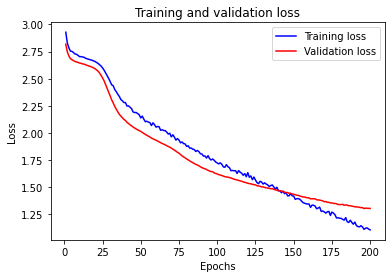

In [46]:
# ploting of loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

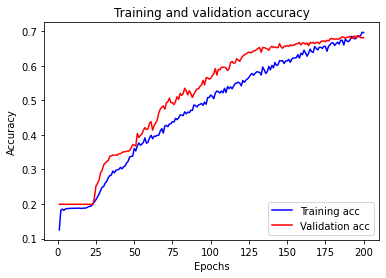

In [47]:
# plotting of accuracy
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Predict

In [59]:
# creating the probability model for testing
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

# predicting test samples
predictions = probability_model.predict(raw_test_batch.map(vectorize_text))

11/11 [==============================] - 0s 2ms/step


In [61]:
# showing the first test sample result label
np.argmax(predictions[0])

17

In [62]:
# showing the true label of the first test sample
test_df.iloc[0]

text         starter pack curly or dry hair nuebar argan oi...
label                                          Health & Beauty
label_int                                                   10
Name: 2991, dtype: object